# Bollinger Bands

## Calculating Bollinger Bands
Steps:
  1. Calculate Middle Band (Mean)
  2. Calculate STD
  3. Calculate Upper Band (Mean + N*STD)
  4. Calculate Upper Band (Mean + N*STD)

## 布林極限指標 (%B):
以數值方式來表示圖形狀況。

${通道寬度(BW) = Upper_{bands} - Lower_{bands}}$

%B = $\dfrac{(close - lower)}{BW}$

透過公式的計算原理不難發現，因為分母是布林通道的範圍大小，所以當指標恰巧為50%的時候，表示收盤價正位於中線，大於50%，表示股價在中線之上，小於50%，則低於中線

## Yahoo finance
use yahoo_fin api to get data.


## 交易設定
* 投資人有總資金 1,000,000。
* 投資三間公司 Netfilx, Tesla, IGS。
* 每間公司各投資總資金的30%。
* 剩下10%留下來跑路。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from yahoo_fin.stock_info import get_data
import plotly.graph_objs as pltgo
%matplotlib inline

## 畫圖、取股票、布林通道設定

In [2]:
# interval format: "1d", "1wk", "1mo"
# date format: mm/dd/yyyy
def get_stock(ticker_list, start_date, end_date, days, N_std, interval="1d"):
    historical_datas = {}
    # Get ticker data
    for ticker in ticker_list:
        historical_datas[ticker] = get_data(ticker, start_date, end_date, interval=interval)

        # Calculate mean, std, upper bands, lower bands
        ticker_data = historical_datas[ticker]
        ticker_data['middle'] = ticker_data['close'].rolling(window=days).mean()
        ticker_data['std'] = ticker_data['close'].rolling(window=days).std()
        ticker_data['lower'] = ticker_data['middle'] - N_std * ticker_data['std']
        ticker_data['upper'] = ticker_data['middle'] + N_std * ticker_data['std']
        ticker_data['B'] = (ticker_data['close'] - ticker_data['lower']) / (ticker_data['upper'] - ticker_data['lower'])
        
    return historical_datas

In [3]:
# DF: Company's historical datas
def show_bollinger(DF, ticker, start_date, end_date, SIG=None):
    plt.figure(figsize=(20,10))
    plt.plot(DF['upper'], color="red")
    plt.plot(DF['middle'], color="blue")
    plt.plot(DF['lower'], color="green")
    plt.plot(DF['close'], color="black")
    if SIG is not None:
        plt.plot(DF['close'][SIG == 1], lw = 0, marker='^', markersize=6, c='g', alpha=0.7)
        plt.plot(DF['close'][SIG == 2], lw = 0, marker='v', markersize=6, c='r', alpha=0.7)
    plt.xlabel('date')
    plt.ylabel('price')
    plt.legend(['upper', 'middle', 'lower', 'close'])
    plt.grid(True)
    plt.title(f"{ticker} Bollinger band {start_date} ~ {end_date}")
    plt.show()

In [4]:
def bollinger_bands(DF, ticker):
    fig = pltgo.Figure()
    
    # Setup traces
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['upper'], line=dict(color='yellow', width=1.7), name = 'Upper Band'))
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['middle'], line=dict(color='blue', width=.7), name = 'Middle Band'))
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['lower'], line=dict(color='yellow', width=1.7), name = 'Lower Band'))
    fig.add_trace(pltgo.Scatter(x=DF.index, y=DF['close'], line=dict(color='black', width=.7), name = 'Close price'))
    
    # candle stick
    fig.add_trace(pltgo.Candlestick(x=DF.index, open=DF['open'], high=DF['high'],
                                    low=DF['low'], close=DF['close'], name="market data"))
    fig.update_layout(title=ticker)
    fig.show()

In [5]:
# draw funding changes
def funding_changes(rec):
  rec= rec[rec['動作']=='SELL']
  plt.figure(figsize=(25, 10))
  plt.plot(rec['日期'], rec['總資金'],color="green")
  plt.title("IGS Funding changes (principal: 300000)")
  plt.show()

In [6]:
def init_account(shares=0.0, cost=0.0, buy_times=0.0, earn=0.0,sell_times=0.0, capital=300000,per_trans=1000):
    account = {
        'shares': shares,     # 有幾股
        'cost': cost,
        'buy_times': buy_times,
        'earn': earn,
        'sell_times': sell_times,
        'capital': capital,  # 資金
        'per_trans': per_trans   # 一次買一張
    }
    return account

In [7]:
def init_rate(fee=0.001425, tax=0.003, slippage=1):
    rate = {
        'handling_fee': fee,
        'trans_tax': tax,
        'slippage': slippage
    }
    return rate

In [8]:
# Data Setup
IGS = "3293.two"
ticker_list = ["tsla", "nflx", IGS]

days = 20
N_std = 2

start_date = "10/01/2018"
end_date = "10/01/2020"

interval = "1d"

# fee tax or something else
rate = init_rate()

In [9]:
historical_datas = get_stock(ticker_list, start_date, end_date, days, N_std)

## 交易策略
### 買低賣高 做空頭
1. close 往上穿過 middle: 買
2. close 往下穿過 middle: 賣
#### 布林通道
3. 高於 upper band 賣
4. 低於 lower band 買

### 停損停利
5. 低於最高點的7%賣
6. 高於 upper band 的 40% 賣

### 策略1
(5) 收盤低於最高點7% 
### 策略2
(5) 開盤低於最高點7% 

In [10]:
def buy(investor, price, rate):
    b_price = investor['per_trans'] * (price + rate['slippage'])
    b_price += b_price * rate['handling_fee']
    investor['cost'] += b_price
    investor['buy_times'] += 1
    investor['shares'] += investor['per_trans']
    investor['capital'] -= b_price
    return investor, b_price

In [11]:
def sell(investor, price, rate):
    b_price = investor['shares'] * (price + rate['slippage'])
    b_price *= (1 - rate['handling_fee'])
    b_price *= (1 - rate['trans_tax'])
    investor['earn'] += b_price
    investor['sell_times'] += 1
    investor['shares'] = 0
    investor['capital'] += b_price
    return investor, b_price

In [12]:
def trade_strategy(today_B, pre_B, raise_rate, drop_rate, today_price, max_price):
    sign="None"
    # Analyze Buy signal
    if pre_B < 0.5 and today_B > 0.5:
        sign = "cross_up"
    elif today_B < 0:
        sign = "low_lower"
    # Analyze Sell signal
    elif pre_B > 0.5 and today_B < 0.5:
        sign = "cross_dwn"
    elif today_B >= raise_rate:
        sign = "up_upper"
    elif today_price < max_price * drop_rate:
        sign = "low_max"
    return sign, today_price

In [13]:
# return company dataframe, transaction record, investor final
def transaction(company, strategy=1):
    # Investor capital
    investor = init_account()
    drop_rate = 0.93
    raise_rate = 1.4
    SIG = np.zeros(len(company))

    pre_close = company['close'][0]
    pre_B = company['B'][0]
    max_close = pre_close
    record = []

    for day in range(1, len(company)):

        today_close = company['close'][day]
        today_open = company['open'][day]
        today_B = company['B'][day]
        
        sign = "None"
        BUY = ["cross_up", "low_lower"]  # 1, 4
        SELL = ["cross_dwn", "up_upper", "low_max"]  # 2, (3/6), 5(st1), 5(st2)
        
        if strategy == 1:
            # 收盤低於最高點7%
            sign, sell_price = trade_strategy(today_B, pre_B, raise_rate, drop_rate, today_close, max_close)
        elif strategy == 2:
            # 開盤低於最高點7%
            sign, sell_price = trade_strategy(today_B, pre_B, raise_rate, drop_rate, today_open, max_close)
            if sign != "low_max":
                sell_price = today_close

        if sign in BUY and investor['shares'] == 0:
            investor, actuall_price = buy(investor, today_close, rate)
            record.append([company.index[day], 'BUY', sign, investor['capital'],
                           investor['shares'], today_close, actuall_price, pre_B, today_B, day])
            SIG[day] = 1
            max_close = today_close
        elif sign in SELL and investor['shares'] != 0:
            investor, actuall_price = sell(investor, sell_price, rate)
            record.append([company.index[day], 'SELL', sign, investor['capital'],
                           investor['shares'], sell_price, actuall_price, pre_B, today_B, day])
            SIG[day] = 2
            max_close = 0

        pre_B = today_B
        pre_close = today_close
        if investor['shares'] != 0:
            max_close = max(today_close, max_close)

    # 清空
    if investor['shares'] != 0:
        investor, actuall_price = sell(investor, pre_close, rate)
        record.append([company.index[day], 'SELL', 'clean', investor['capital'],
                           investor['shares'], pre_close, actuall_price, pre_B, today_B, day])
        SIG[day] = 0
    print(f"Total Earn: {investor['earn'] - investor['cost']}")
    record = pd.DataFrame(record, columns=['日期', '動作', '指標', '總資金', '持有股', '交易每股金額', '實際買賣金額', '昨天%B', '今天%B', 'Index'])
    return record, investor, SIG

## IGS

In [14]:
IGS_df = historical_datas[IGS]
IGS_df

open   high    low  close    adjclose   volume    ticker  middle  \
2018-10-01  148.5  151.0  148.5  150.0  141.456970   169500  3293.TWO     NaN   
2018-10-02  150.5  150.5  148.5  149.0  140.513931    80110  3293.TWO     NaN   
2018-10-03  150.5  150.5  147.0  147.0  138.627853   103150  3293.TWO     NaN   
2018-10-04  148.5  148.5  146.5  147.0  138.627853    44301  3293.TWO     NaN   
2018-10-05  144.0  144.5  138.0  141.5  133.441086   569468  3293.TWO     NaN   
...           ...    ...    ...    ...         ...      ...       ...     ...   
2020-09-24  803.0  805.0  773.0  780.0  780.000000  1767000  3293.TWO  848.10   
2020-09-25  784.0  792.0  752.0  760.0  760.000000  1794000  3293.TWO  841.60   
2020-09-28  771.0  773.0  748.0  758.0  758.000000  1137000  3293.TWO  835.50   
2020-09-29  765.0  783.0  759.0  763.0  763.000000  1254000  3293.TWO  826.00   
2020-09-30  765.0  771.0  755.0  771.0  771.000000   731000  3293.TWO  818.35   

                  std       lower       upper         B  
2018-10-01        NaN         NaN         NaN       NaN  
2018-10-02        NaN         NaN         NaN       NaN  
2018-10-03        NaN         NaN         NaN       NaN  
2018-10-04        NaN         NaN         NaN       NaN  
2018-10-05        NaN         NaN         NaN       NaN  
...               ...         ...         ...       ...  
2020-09-24  51.157034  745.785932  950.414068  0.167201  
2020-09-25  53.746383  734.107234  949.092766  0.120440  
2020-09-28  56.033355  723.433291  947.566709  0.154224  
2020-09-29  50.938559  724.122881  927.877119  0.190804  
2020-09-30  46.763993  724.822014  911.877986  0.246867  

[487 rows x 12 columns]

In [15]:
# 策略1
IGS_rec, IGS_iv, IGS_sig = transaction(historical_datas[IGS])

Total Earn: 589742.3969374988


In [16]:
# 策略2
IGS_rec2, IGS_iv2, IGS_sig2 = transaction(historical_datas[IGS], 2)

Total Earn: 573813.1285375003


In [17]:
IGS_iv

{'shares': 0,
 'cost': 9318760.3375,
 'buy_times': 23.0,
 'earn': 9908502.7344375,
 'sell_times': 23.0,
 'capital': 889742.3969375,
 'per_trans': 1000}

In [18]:
result = pd.concat([IGS_rec, IGS_rec2], axis=1)
result

日期    動作         指標            總資金     持有股  交易每股金額         實際買賣金額  \
0  2018-10-31   BUY   cross_up  161302.637500  1000.0   137.5  138697.362500   
1  2018-12-20  SELL  cross_dwn  306657.211650     0.0   145.0  145354.574150   
2  2019-01-08   BUY   cross_up  156944.174150  1000.0   148.5  149713.037500   
3  2019-03-21  SELL    low_max  363526.873712     0.0   206.5  206582.699562   
4  2019-04-08   BUY   cross_up  142211.948712  1000.0   220.0  221314.925000   
5  2019-04-26  SELL    low_max  387124.450363     0.0   245.0  244912.501650   
6  2019-05-14   BUY   cross_up  130258.937863  1000.0   255.5  256865.512500   
7  2019-05-20  SELL  cross_dwn  381642.704800     0.0   251.5  251383.766938   
8  2019-05-29   BUY   cross_up  117266.504800  1000.0   263.0  264376.200000   
9  2019-07-02  SELL  cross_dwn  411957.970200     0.0   295.0  294691.465400   
10 2019-07-03   BUY   cross_up  103519.070200  1000.0   307.0  308438.900000   
11 2019-07-10  SELL  cross_dwn  406672.959438     0.0   303.5  303153.889238   
12 2019-07-11   BUY   cross_up   95730.496938  1000.0   309.5  310942.462500   
13 2019-07-18  SELL  cross_dwn  402368.913638     0.0   307.0  306638.416700   
14 2019-07-29   BUY   cross_up   90425.026138  1000.0   310.5  311943.887500   
15 2019-07-30  SELL  cross_dwn  395570.073925     0.0   305.5  305145.047787   
16 2019-07-31   BUY   cross_up   84627.611425  1000.0   309.5  310942.462500   
17 2019-08-02  SELL  cross_dwn  390270.448850     0.0   306.0  305642.837425   
18 2019-08-06   BUY   cross_up   52289.511350  1000.0   336.5  337980.937500   
19 2019-08-07  SELL   up_upper  421649.422375     0.0   370.0  369359.911025   
20 2019-09-03   BUY   cross_up   35600.084875  1000.0   384.5  386049.337500   
21 2019-09-05  SELL  cross_dwn  415413.578288     0.0   380.5  379813.493413   
22 2019-09-24   BUY   cross_up   19349.990787  1000.0   394.5  396063.587500   
23 2019-10-08  SELL  cross_dwn  408123.697675     0.0   389.5  388773.706887   
24 2019-10-31   BUY   cross_up   14563.672675  1000.0   392.0  393560.025000   
25 2019-11-08  SELL  cross_dwn  402839.589925     0.0   389.0  388275.917250   
26 2019-11-18   BUY  low_lower   44830.152425  1000.0   356.5  358009.437500   
27 2019-12-05  SELL    low_max  387309.423025     0.0   343.0  342479.270600   
28 2019-12-06   BUY   cross_up   11274.335525  1000.0   374.5  376035.087500   
29 2019-12-13  SELL  cross_dwn  372171.822712     0.0   361.5  360897.487187   
30 2019-12-16   BUY   cross_up   -7368.252288  1000.0   378.0  379540.075000   
31 2020-03-04  SELL    low_max  573054.465037     0.0   582.0  580422.717325   
32 2020-03-19   BUY  low_lower  123414.640037  1000.0   448.0  449639.825000   
33 2020-04-17  SELL  cross_dwn  668992.082737     0.0   547.0  545577.442700   
34 2020-04-22   BUY   cross_up   90168.432737  1000.0   577.0  578823.650000   
35 2020-04-24  SELL  cross_dwn  654661.881662     0.0   566.0  564493.448925   
36 2020-04-29   BUY   cross_up   74836.806662  1000.0   578.0  579825.075000   
37 2020-04-30  SELL  cross_dwn  631365.621387     0.0   558.0  556528.814725   
38 2020-05-04   BUY  low_lower  111626.046387  1000.0   518.0  519739.575000   
39 2020-07-15  SELL    low_max  889173.460162     0.0   780.0  777547.413775   
40 2020-08-06   BUY   cross_up  115071.935162  1000.0   772.0  774101.525000   
41 2020-08-11  SELL  cross_dwn  849809.440112     0.0   737.0  734737.504950   
42 2020-08-12   BUY   cross_up   86723.590112  1000.0   761.0  763085.850000   
43 2020-08-13  SELL  cross_dwn  817478.777962     0.0   733.0  730755.187850   
44 2020-08-14   BUY   cross_up   64407.177962  1000.0   751.0  753071.600000   
45 2020-09-07  SELL  cross_dwn  889742.396937     0.0   828.0  825335.218975   

        昨天%B      今天%B  Index         日期    動作         指標            總資金  \
0   0.270870  0.512240     21 2018-10-31   BUY   cross_up  161302.637500   
1   0.517873  0.239420     57 2018-12-20  SELL  cross_dwn  306657.211650   
2   0.396568  0.648676

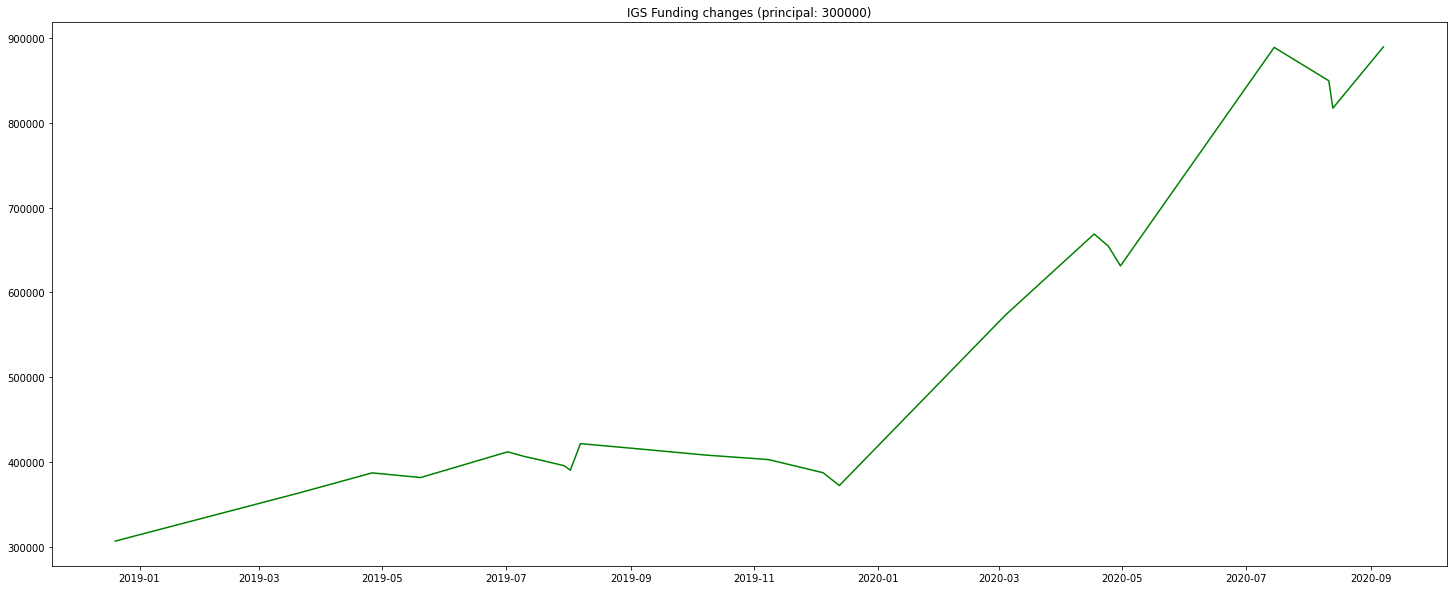

In [19]:
funding_changes(IGS_rec)

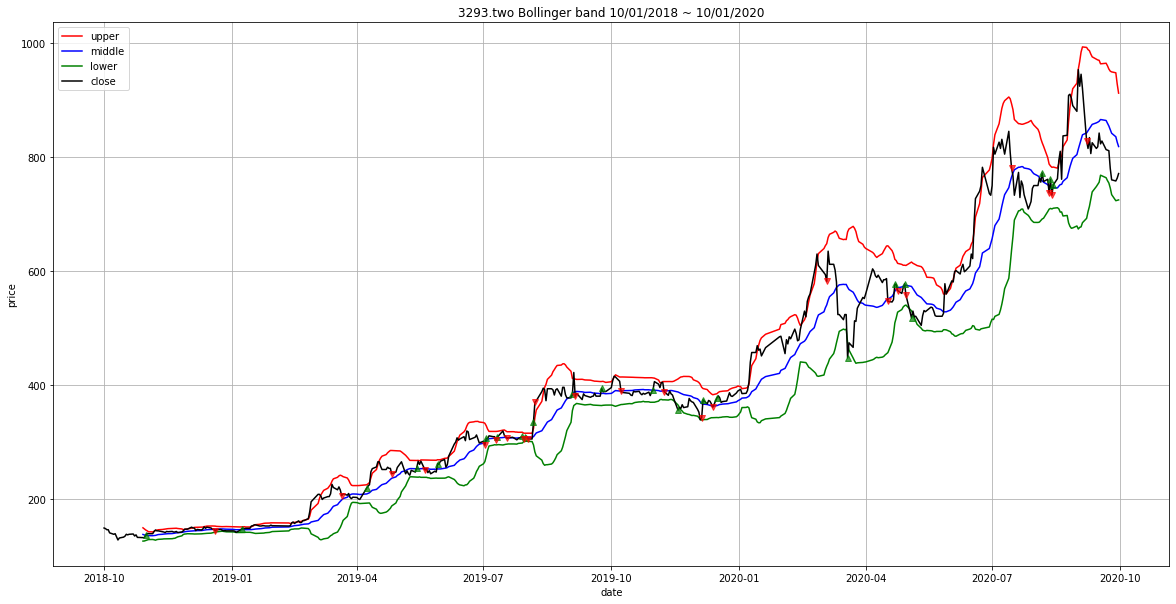

In [20]:
# 策略1
show_bollinger(IGS_df, IGS, start_date, end_date, IGS_sig)

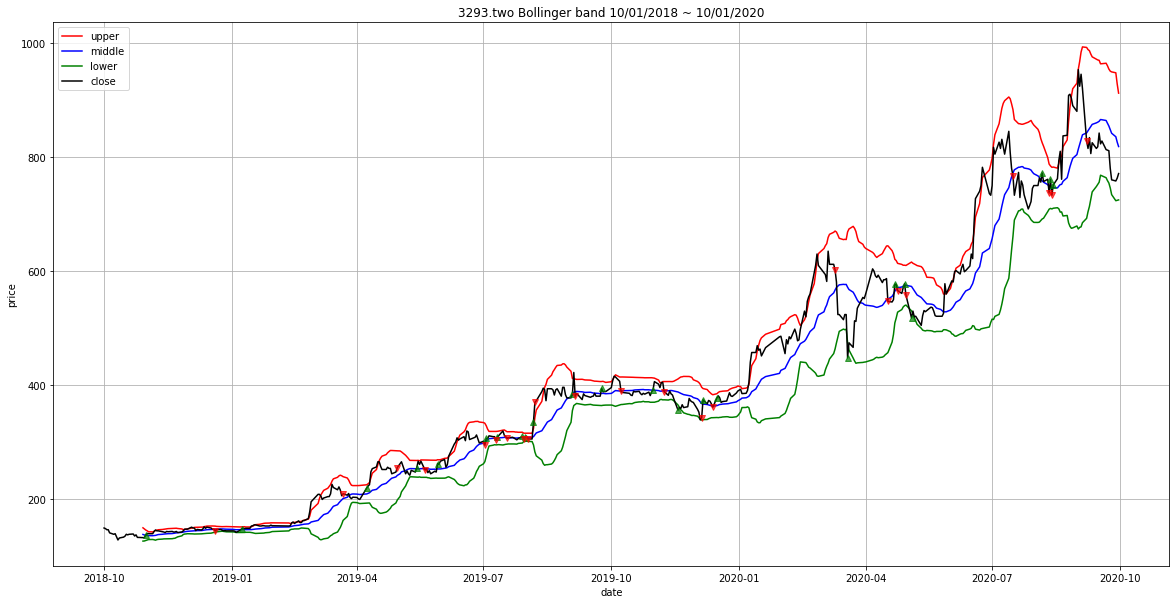

In [21]:
# 策略2
show_bollinger(IGS_df, IGS, start_date, end_date, IGS_sig2)

## Netflix

In [22]:
nflx_df = historical_datas["nflx"]
nflx_df

open        high         low       close    adjclose  \
2018-10-01  375.850006  386.109985  375.589996  381.429993  381.429993   
2018-10-02  384.380005  386.799988  373.829987  377.140015  377.140015   
2018-10-03  378.529999  380.929993  374.880005  377.049988  377.049988   
2018-10-04  375.880005  375.920013  360.399994  363.649994  363.649994   
2018-10-05  359.769989  363.500000  343.000000  351.350006  351.350006   
...                ...         ...         ...         ...         ...   
2020-09-24  470.529999  477.000000  467.820007  473.079987  473.079987   
2020-09-25  474.390015  484.869995  468.029999  482.880005  482.880005   
2020-09-28  489.109985  492.000000  477.880005  490.649994  490.649994   
2020-09-29  489.500000  496.290009  486.529999  493.480011  493.480011   
2020-09-30  492.570007  504.630005  489.269989  500.029999  500.029999   

              volume ticker      middle        std       lower       upper  \
2018-10-01   8376600   NFLX         NaN        NaN         NaN         NaN   
2018-10-02   8638700   NFLX         NaN        NaN         NaN         NaN   
2018-10-03   5798600   NFLX         NaN        NaN         NaN         NaN   
2018-10-04   9074400   NFLX         NaN        NaN         NaN         NaN   
2018-10-05  13523000   NFLX         NaN        NaN         NaN         NaN   
...              ...    ...         ...        ...         ...         ...   
2020-09-24   3727200   NFLX  500.965001  27.366514  446.231974  555.698028   
2020-09-25   3769400   NFLX  498.795500  26.971899  444.851701  552.739299   
2020-09-28   4773500   NFLX  497.133499  26.361409  444.410682  549.856316   
2020-09-29   3541500   NFLX  495.329500  25.236080  444.857339  545.801661   
2020-09-30   4631100   NFLX  492.503500  20.793162  450.917176  534.089825   

                   B  
2018-10-01       NaN  
2018-10-02       NaN  
2018-10-03       NaN  
2018-10-04       NaN  
2018-10-05       NaN  
...              ...  
2020-09-24  0.245263  
2020-09-25  0.352481  
2020-09-28  0.438513  
2020-09-29  0.481678  
2020-09-30  0.590492  

[504 rows x 12 columns]

In [23]:
nflx_rec, nflx_iv, nflx_sig = transaction(historical_datas["nflx"])

Total Earn: 81249.88364403881


In [24]:
nflx_rec2, nflx_iv2, nflx_sig2 = transaction(historical_datas["nflx"], 2)

Total Earn: 61895.85049009323


In [25]:
nflx_iv

{'shares': 0,
 'cost': 12182405.094559861,
 'buy_times': 33.0,
 'earn': 12263654.9782039,
 'sell_times': 33.0,
 'capital': 381249.88364404085,
 'per_trans': 1000}

In [26]:
result = pd.concat([nflx_rec, nflx_rec2], axis=1)
result

日期    動作         指標            總資金     持有股      交易每股金額  \
0  2018-10-29   BUY  low_lower   13752.681667  1000.0  284.839996   
1  2018-11-08  SELL  cross_dwn  331262.837419     0.0  317.920013   
2  2018-12-03   BUY   cross_up   39547.747143  1000.0  290.299988   
3  2018-12-04  SELL  cross_dwn  314656.154836     0.0  275.329987   
4  2018-12-13   BUY   cross_up   37241.412337  1000.0  276.019989   
..        ...   ...        ...            ...     ...         ...   
61 2020-08-24  SELL  cross_dwn  361695.003301     0.0  488.809998   
62 2020-08-25   BUY   cross_up -130585.484752  1000.0  490.579987   
63 2020-09-04  SELL    low_max  384178.767234     0.0  516.049988   
64 2020-09-30   BUY   cross_up -117565.199294  1000.0  500.029999   
65 2020-09-30  SELL      clean  381249.883644     0.0  500.029999   

           實際買賣金額      昨天%B      今天%B  Index         日期    動作         指標  \
0   286247.318333  0.054491 -0.022319     20 2018-10-29   BUY  low_lower   
1   317510.155751  0.581762  0.468341     28 2018-11-08  SELL  cross_dwn   
2   291715.090276  0.464992  0.528232     44 2018-12-03   BUY   cross_up   
3   275108.407692  0.528232  0.358924     45 2018-12-04  SELL  cross_dwn   
4   277414.742498  0.469988  0.516144     51 2018-12-13   BUY   cross_up   
..            ...       ...       ...    ...        ...   ...        ...   
61  487644.682257  0.558675  0.484353    477 2020-08-24  SELL  cross_dwn   
62  492280.488053  0.484353  0.523830    478 2020-08-25   BUY   cross_up   
63  514764.251986  0.700320  0.602067    486 2020-09-08  SELL    low_max   
64  501743.966528  0.481678  0.590492    503 2020-09-30   BUY   cross_up   
65  498815.082938  0.590492  0.590492    503 2020-09-30  SELL      clean   

              總資金     持有股      交易每股金額         實際買賣金額      昨天%B      今天%B  \
0    13752.681667  1000.0  284.839996  286247.318333  0.054491 -0.022319   
1   331262.837419     0.0  317.920013  317510.155751  0.581762  0.468341   
2    39547.747143  1000.0  290.299988  291715.090276  0.464992  0.528232   
3   314656.154836     0.0  275.329987  275108.407692  0.528232  0.358924   
4    37241.412337  1000.0  276.019989  277414.742498  0.469988  0.516144   
..            ...     ...         ...            ...       ...       ...   
61  359912.938274     0.0  488.809998  487644.682257  0.558675  0.484353   
62 -132367.549779  1000.0  490.579987  492280.488053  0.484353  0.523830   
63  364824.734080     0.0  498.399994  497192.283858  0.602067  0.509336   
64 -136919.232448  1000.0  500.029999  501743.966528  0.481678  0.590492   
65  361895.850490     0.0  500.029999  498815.082938  0.590492  0.590492   

    Index  
0      20  
1      28  
2      44  
3      45  
4      51  
..    ...  
61    477  
62    478  
63    487  
64    503  
65    503  

[66 rows x 20 columns]

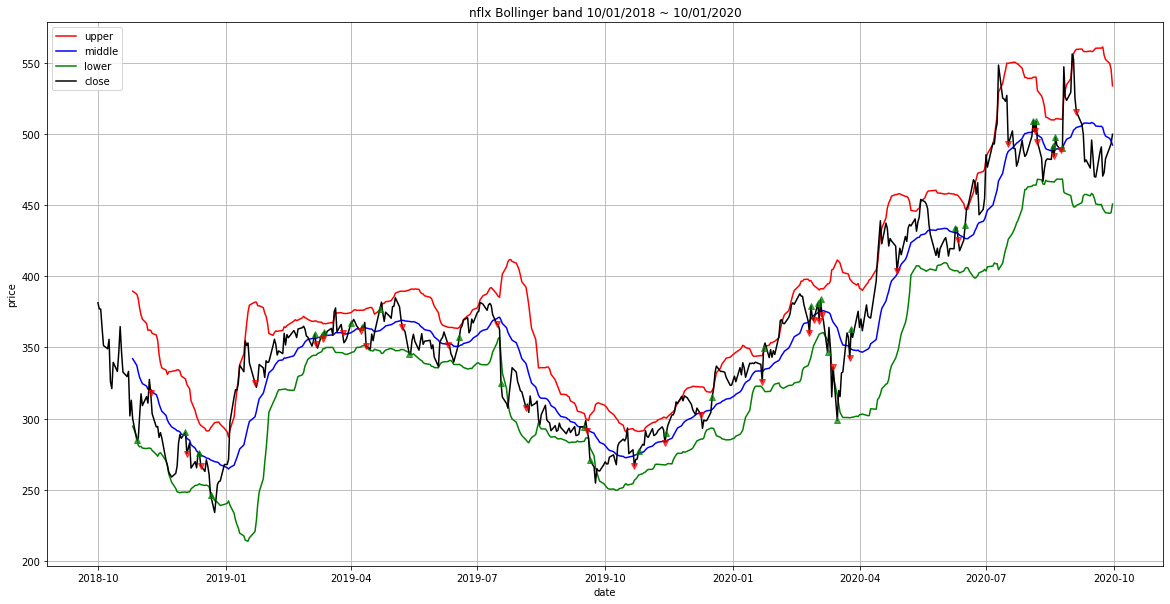

In [27]:
show_bollinger(nflx_df, "nflx", start_date, end_date, nflx_sig)

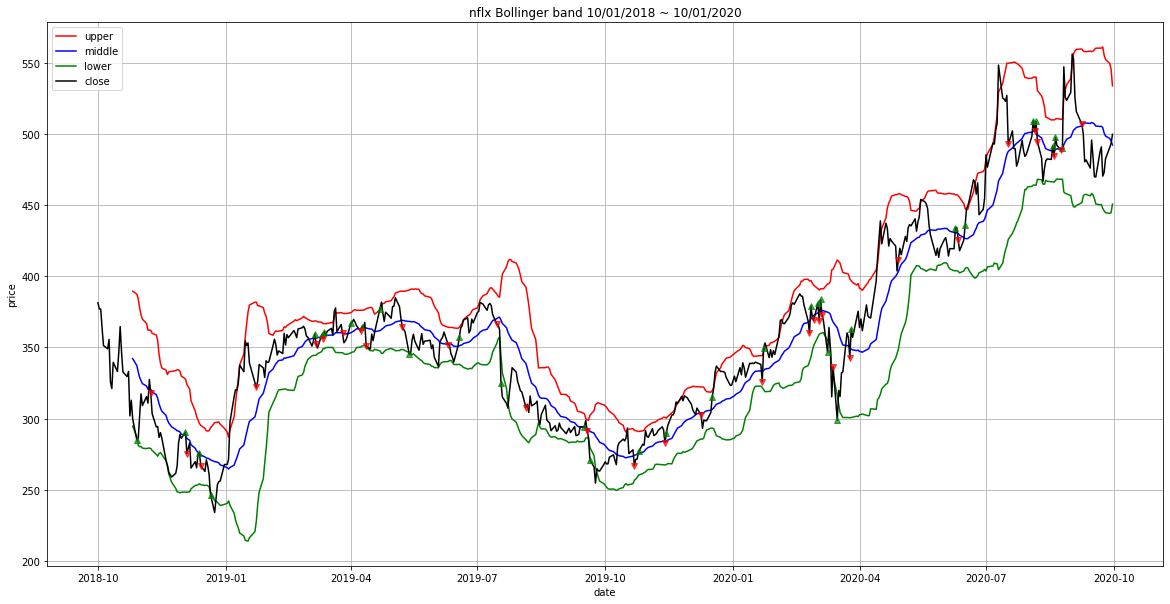

In [28]:
show_bollinger(nflx_df, "nflx", start_date, end_date, nflx_sig2)

## Tesla

In [29]:
tsla_df = historical_datas["tsla"]
tsla_df

open        high         low       close    adjclose  \
2018-10-01   61.153999   62.287998   60.209999   62.139999   62.139999   
2018-10-02   62.790001   63.368000   59.830002   60.203999   60.203999   
2018-10-03   60.666000   60.919998   58.313999   58.959999   58.959999   
2018-10-04   58.790001   58.799999   55.534000   56.366001   56.366001   
2018-10-05   54.930000   54.976002   52.000000   52.389999   52.389999   
...                ...         ...         ...         ...         ...   
2020-09-24  363.799988  399.500000  351.299988  387.790009  387.790009   
2020-09-25  393.470001  408.730011  391.299988  407.339996  407.339996   
2020-09-28  424.619995  428.079987  415.549988  421.200012  421.200012   
2020-09-29  416.000000  428.500000  411.600006  419.070007  419.070007   
2020-09-30  421.320007  433.929993  420.470001  429.010010  429.010010   

               volume ticker      middle        std       lower       upper  \
2018-10-01  108888000   TSLA         NaN        NaN         NaN         NaN   
2018-10-02   58717500   TSLA         NaN        NaN         NaN         NaN   
2018-10-03   39975000   TSLA         NaN        NaN         NaN         NaN   
2018-10-04   49071000   TSLA         NaN        NaN         NaN         NaN   
2018-10-05   89722500   TSLA         NaN        NaN         NaN         NaN   
...               ...    ...         ...        ...         ...         ...   
2020-09-24   96561100   TSLA  419.776500  41.213408  337.349683  502.203317   
2020-09-25   67208500   TSLA  417.756000  40.757858  336.240283  499.271716   
2020-09-28   49719600   TSLA  416.682001  40.347467  335.987067  497.376934   
2020-09-29   50219300   TSLA  412.719501  35.509342  341.700817  483.738184   
2020-09-30   48145600   TSLA  410.417502  32.631645  345.154212  475.680792   

                   B  
2018-10-01       NaN  
2018-10-02       NaN  
2018-10-03       NaN  
2018-10-04       NaN  
2018-10-05       NaN  
...              ...  
2020-09-24  0.305970  
2020-09-25  0.436110  
2020-09-28  0.527994  
2020-09-29  0.544710  
2020-09-30  0.642442  

[504 rows x 12 columns]

In [30]:
tsla_rec, tsla_iv, tsla_sig = transaction(historical_datas["tsla"])

Total Earn: 185850.73868601676


In [31]:
tsla_rec2, tsla_iv2, tsla_sig2 = transaction(historical_datas["tsla"], 2)

Total Earn: 118181.26352079632


In [32]:
tsla_iv

{'shares': 0,
 'cost': 2641162.2962075234,
 'buy_times': 26.0,
 'earn': 2827013.03489354,
 'sell_times': 26.0,
 'capital': 485850.7386860174,
 'per_trans': 1000}

In [33]:
result = pd.concat([tsla_rec, tsla_rec2], axis=1)
result

日期    動作         指標            總資金     持有股      交易每股金額  \
0  2018-11-26   BUY   cross_up  229699.968056  1000.0   69.199997   
1  2018-11-29  SELL  cross_dwn  298627.904736     0.0   68.234001   
2  2018-11-30   BUY   cross_up  227430.592264  1000.0   70.096001   
3  2018-12-17  SELL  cross_dwn  297802.115854     0.0   69.683998   
4  2018-12-20   BUY  low_lower  233634.807340  1000.0   63.076000   
5  2019-01-02  SELL    low_max  296380.193836     0.0   62.023998   
6  2019-01-08   BUY   cross_up  228213.194392  1000.0   67.070000   
7  2019-01-18  SELL  cross_dwn  289393.531665     0.0   60.452000   
8  2019-02-05   BUY   cross_up  224030.525276  1000.0   64.269997   
9  2019-02-06  SELL  cross_dwn  288189.636317     0.0   63.444000   
10 2019-02-11   BUY   cross_up  224531.051123  1000.0   62.568001   
11 2019-02-13  SELL  cross_dwn  286888.162309     0.0   61.633999   
12 2019-02-15   BUY   cross_up  224222.991295  1000.0   61.576000   
13 2019-02-20  SELL  cross_dwn  285463.064692     0.0   60.512001   
14 2019-02-27   BUY   cross_up  221423.936928  1000.0   62.948002   
15 2019-03-01  SELL  cross_dwn  281116.879280     0.0   58.958000   
16 2019-03-04   BUY  low_lower  222962.128086  1000.0   57.071999   
17 2019-03-18  SELL    low_max  277617.437940     0.0   53.897999   
18 2019-03-28   BUY   cross_up  220812.607218  1000.0   55.723999   
19 2019-04-04  SELL  cross_dwn  275127.429902     0.0   53.556000   
20 2019-04-10   BUY   cross_up  218835.325999  1000.0   55.212002   
21 2019-04-11  SELL  cross_dwn  273277.581189     0.0   53.683998   
22 2019-04-25   BUY  low_lower  222679.580661  1000.0   49.526001   
23 2019-05-13  SELL    low_max  268876.450605     0.0   45.402000   
24 2019-05-17   BUY  low_lower  225608.880772  1000.0   42.206001   
25 2019-05-23  SELL    low_max  265529.618115     0.0   39.098000   
26 2019-06-10   BUY   cross_up  221891.522101  1000.0   42.576000   
27 2019-07-25  SELL  cross_dwn  268448.791257     0.0   45.764000   
28 2019-08-23   BUY  low_lower  225107.118479  1000.0   42.279999   
29 2019-09-04  SELL  cross_dwn  270043.586216     0.0   44.136002   
30 2019-09-05   BUY   cross_up  223060.730549  1000.0   45.916000   
31 2019-09-24  SELL  cross_dwn  268500.958117     0.0   44.641998   
32 2019-09-26   BUY   cross_up  218918.402478  1000.0   48.512001   
33 2019-10-03  SELL  cross_dwn  266313.948441     0.0   46.605999   
34 2019-10-09   BUY   cross_up  216336.834163  1000.0   48.905998   
35 2019-11-22  SELL  cross_dwn  283645.959489     0.0   66.608002   
36 2019-11-25   BUY   cross_up  215280.679851  1000.0   67.267998   
37 2019-11-26  SELL  cross_dwn  281769.442749     0.0   65.783997   
38 2019-12-10   BUY   cross_up  210900.600611  1000.0   69.767998   
39 2020-02-05  SELL    low_max  358186.600985     0.0  146.940002   
40 2020-03-09   BUY  low_lower  235411.897513  1000.0  121.599998   
41 2020-03-12  SELL    low_max  348021.869916     0.0  112.110001   
42 2020-03-16   BUY  low_lower  257879.600027  1000.0   89.014000   
43 2020-04-01  SELL    low_max  354761.406911     0.0   96.311996   
44 2020-04-06   BUY   cross_up  250364.852411  1000.0  103.248001   
45 2020-04-21  SELL    low_max  388097.265798     0.0  137.343994   
46 2020-08-12   BUY   cross_up   75700.738355  1000.0  310.951996   
47 2020-09-02  SELL    low_max  522088.613025     0.0  447.369995   
48 2020-09-14   BUY   cross_up  100869.234415  1000.0  419.619995   
49 2020-09-23  SELL  cross_dwn  480543.332145     0.0  380.359985   
50 2020-09-28   BUY   cross_up   57741.684921  1000.0  421.200012   
51 2020-09-30  SELL      clean  485850.738686     0.0  429.010010   

           實際買賣金額      昨天%B      今天%B  Index         日期    動作         指標  \
0    70300.031944  0.019443  0.604818     39 2018-11-26   BUY   cross_up   
1    68927.936680  0.634545  0.392636     42 2018-11-29  SELL  cross_dwn   
2    71197.312472  0.392636  0.707863     43 2018-11-30   BUY   cross_up   
3    70371.523590  0.746041  0.386771     53 2018

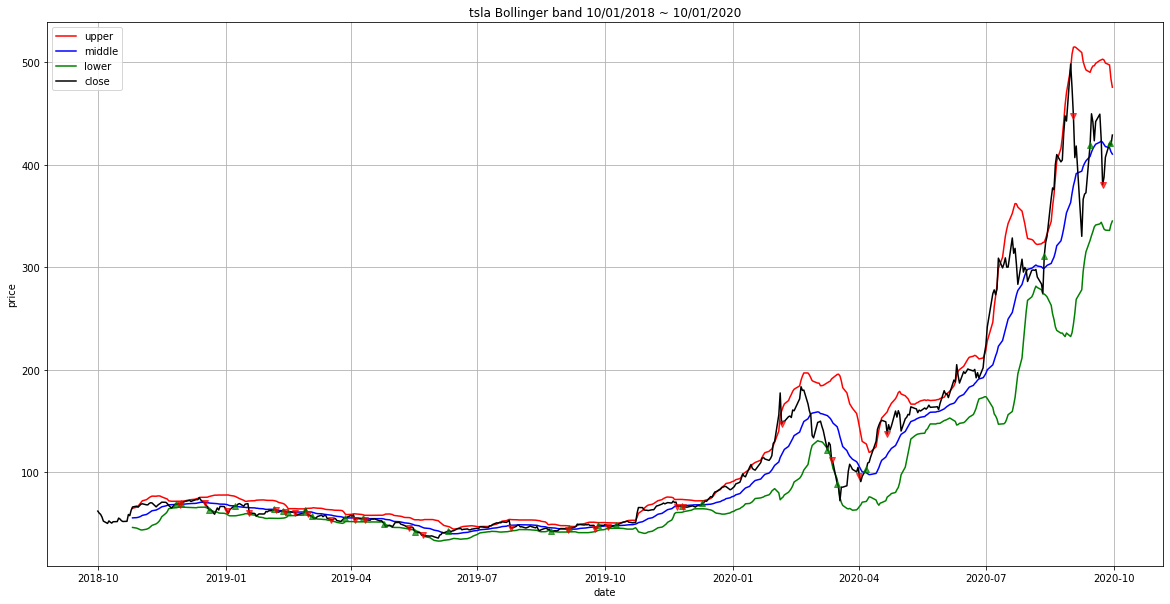

In [34]:
show_bollinger(tsla_df, "tsla", start_date, end_date, tsla_sig)

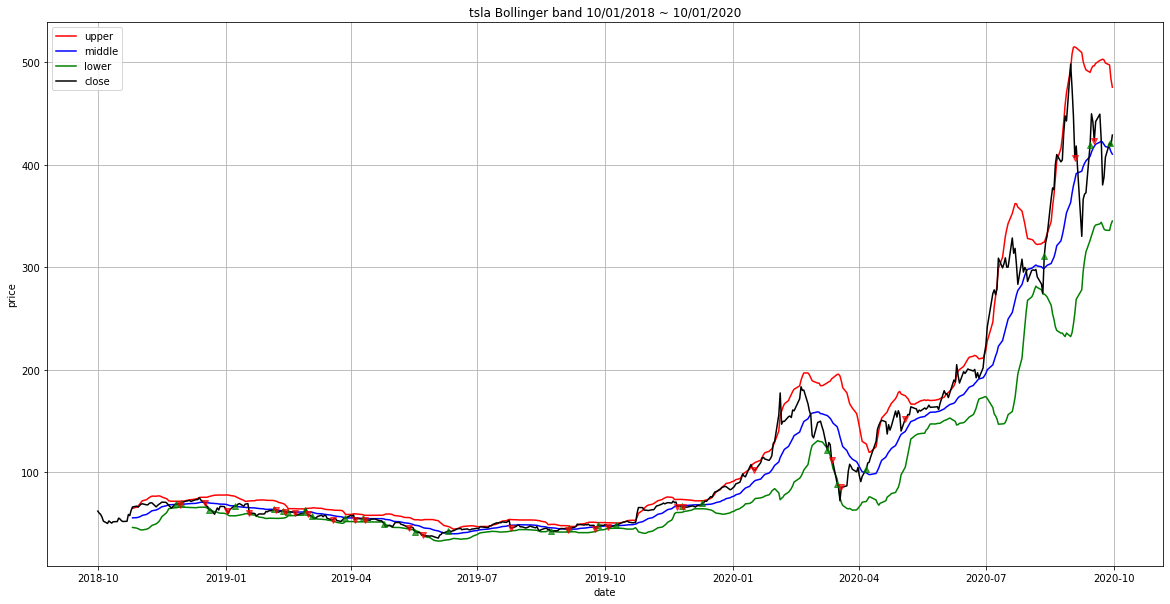

In [35]:
show_bollinger(tsla_df, "tsla", start_date, end_date, tsla_sig2)

In [36]:
bollinger_bands(historical_datas[IGS], IGS)

## Compare Companys

In [37]:
# return company dataframe, transaction record, investor final
def compareCompanys(ticker_list, strategy=1):
    results= []
    companys = get_stock(ticker_list, start_date, end_date, days, N_std)
    for i in range(len(companys)):
        # Investor capital
        investor = init_account()
        drop_rate = 0.93
        raise_rate = 1.4
        
        company = companys[ticker_list[i]]
        pre_close = company['close'][0]
        pre_B = company['B'][0]
        max_close = pre_close

        for day in range(1, len(company)):

            today_close = company['close'][day]
            today_open = company['open'][day]
            today_B = company['B'][day]

            sign = "None"
            BUY = ["cross_up", "low_lower"]  # 1, 4
            SELL = ["cross_dwn", "up_upper", "low_max"]  # 2, (3/6), 5

            if strategy == 1:
                # 收盤低於最高點7%
                sign, sell_price = trade_strategy(today_B, pre_B, raise_rate, drop_rate, today_close, max_close)
            elif strategy == 2:
                # 開盤低於最高點7%
                sign, sell_price = trade_strategy(today_B, pre_B, raise_rate, drop_rate, today_open, max_close)
                if sign != "low_max":
                    sell_price = today_close

            if sign in BUY and investor['shares'] == 0:
                investor, actuall_price = buy(investor, today_close, rate)
                max_close = today_close
            elif sign in SELL and investor['shares'] != 0:
                investor, actuall_price = sell(investor, sell_price, rate)
                max_close = 0

            pre_B = today_B
            pre_close = today_close
            if investor['shares'] != 0:
                max_close = max(today_close, max_close)

        # 清空
        if investor['shares'] != 0:
            investor, _ = sell(investor, pre_close, rate)
        print(f"Total Earn: {investor['earn'] - investor['cost']}")
        results.append([ticker_list[i], investor['earn']-investor['cost'], investor['earn'],
                        investor['cost'], investor['buy_times'], investor['sell_times']])
    return pd.DataFrame(results, columns=['公司', '獲利', '收入', '花費', '買(次數)', '賣(次數)'])

In [38]:
compareCompanys(ticker_list, 1)

Total Earn: 185850.73868601676
Total Earn: 81249.88364403881
Total Earn: 589742.3969374988


公司             獲利            收入            花費  買(次數)  賣(次數)
0      tsla  185850.738686  2.827013e+06  2.641162e+06   26.0   26.0
1      nflx   81249.883644  1.226365e+07  1.218241e+07   33.0   33.0
2  3293.two  589742.396937  9.908503e+06  9.318760e+06   23.0   23.0

In [39]:
compareCompanys(ticker_list, 2)

Total Earn: 118181.26352079632
Total Earn: 61895.85049009323
Total Earn: 573813.1285375003


公司             獲利            收入            花費  買(次數)  賣(次數)
0      tsla  118181.263521  2.759344e+06  2.641162e+06   26.0   26.0
1      nflx   61895.850490  1.224430e+07  1.218241e+07   33.0   33.0
2  3293.two  573813.128538  9.892573e+06  9.318760e+06   23.0   23.0

## 盈虧比

In [40]:
def profit_loss_analysis(df_rec):

  list_buy = list(df_rec[df_rec['動作'] == 'BUY']['交易每股金額'])
  list_sell = list(df_rec[df_rec['動作'] == 'SELL']['交易每股金額'])

  total_win = 0.0
  total_loss = 0.0
  win_times = 0
  loss_times = 0

  for i in range(len(list_sell)):
    gain = list_sell[i] - list_buy[i]
    if gain > 0:
      total_win += gain
      win_times += 1
    elif gain <= 0:
      total_loss += gain
      loss_times += 1

  print('-------------------------\n')
  print('total win: ' + str(total_win) + ' （每一持有股 賣掉金額 - 買入金額 > 0 的加總）')
  print('total loss: '+ str(total_loss) + ' （每一持有股 賣掉金額 - 買入金額 < 0 的加總）')
  print('\n-------------------------\n')
  print('total sell times: ', win_times + loss_times)
  print('win times: ', win_times)
  print('loss times: ', loss_times)
  win_rate = win_times / (win_times + loss_times)
  print('win rate: ' + str(win_rate * 100)[:5] + '%')
  print('\n-------------------------\n')
  print('average win: ' + str(total_win / win_times) + ' （ total win / win times ）')
  print('average loss: ' + str(total_loss / loss_times) + ' （ total loss / loss times ）')
  profit_loss_ratio = abs((total_win / win_times) / (total_loss / loss_times))
  print('the profit and loss ratio: ' + str(profit_loss_ratio)[:5] + '% ' + ' （ |average win / average loss|% 即盈虧比 ）')
  print('\nexpected value: ' + str(profit_loss_ratio * win_rate - (1 - win_rate)) + ' （ 期望值 ＝（盈虧比 x 勝率）–（1 - 勝率）, 意味著投入$1可以獲得多少回報 ）')
  print('\n-------------------------')

In [41]:
profit_loss_analysis(nflx_rec)

-------------------------

total win: 334.97999572753906 （每一持有股 賣掉金額 - 買入金額 > 0 的加總）
total loss: -181.93991088867188 （每一持有股 賣掉金額 - 買入金額 < 0 的加總）

-------------------------

total sell times:  33
win times:  12
loss times:  21
win rate: 36.36%

-------------------------

average win: 27.91499964396159 （ total win / win times ）
average loss: -8.663805280412946 （ total loss / loss times ）
the profit and loss ratio: 3.222%  （ |average win / average loss|% 即盈虧比 ）

expected value: 0.5352819203976246 （ 期望值 ＝（盈虧比 x 勝率）–（1 - 勝率）, 意味著投入$1可以獲得多少回報 ）

-------------------------


In [42]:
profit_loss_analysis(nflx_rec2)

-------------------------

total win: 318.00001525878906 （每一持有股 賣掉金額 - 買入金額 > 0 的加總）
total loss: -184.39990234375 （每一持有股 賣掉金額 - 買入金額 < 0 的加總）

-------------------------

total sell times:  33
win times:  12
loss times:  21
win rate: 36.36%

-------------------------

average win: 26.500001271565754 （ total win / win times ）
average loss: -8.780947730654763 （ total loss / loss times ）
the profit and loss ratio: 3.017%  （ |average win / average loss|% 即盈虧比 ）

expected value: 0.4610536805747295 （ 期望值 ＝（盈虧比 x 勝率）–（1 - 勝率）, 意味著投入$1可以獲得多少回報 ）

-------------------------


In [43]:
profit_loss_analysis(tsla_rec)

-------------------------

total win: 285.5399971008301 （每一持有股 賣掉金額 - 買入金額 > 0 的加總）
total loss: -83.37801742553711 （每一持有股 賣掉金額 - 買入金額 < 0 的加總）

-------------------------

total sell times:  26
win times:  8
loss times:  18
win rate: 30.76%

-------------------------

average win: 35.69249963760376 （ total win / win times ）
average loss: -4.6321120791965065 （ total loss / loss times ）
the profit and loss ratio: 7.705%  （ |average win / average loss|% 即盈虧比 ）

expected value: 1.6785994431487896 （ 期望值 ＝（盈虧比 x 勝率）–（1 - 勝率）, 意味著投入$1可以獲得多少回報 ）

-------------------------
